# Import dataset

In [ ]:
!pip install wget -q

In [ ]:
import wget, os, gzip, pickle, random, re, sys
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, stdev
import seaborn as sns

In [ ]:
IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'
PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

In [ ]:
def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

In [ ]:
np.random.seed(1)
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [ ]:
def varLenLoader(X, y, batch_size):
  X = np.array(X)
  total_len = len(X)
  for i in np.arange(0, X.shape[0], batch_size):
    x_temp = X[i:i + batch_size]
    y_mini = y[i:i + batch_size]
    ln = np.array([len(x) for x in x_temp])
    batch_length = ln.max()
    x_min = []
    for x in x_temp:
      leng = len(x)
      if leng < batch_length:
        x_min.append(x+[w2i['.pad'] for x in range(batch_length - leng)])
      else: x_min.append(x)
    x_min = torch.tensor(x_min, dtype=torch.long)
    y_mini = torch.tensor(y_mini)
    if len(y_mini) == batch_size:
      yield (x_min, y_mini)
    else: 
      pass 

# for inputs, target in varLenLoader(x_train, y_train, batch_size=500):
#   print(target.size())

# 2. Build Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim=300):
    super(RNN, self).__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim)   
    self.fc1 = nn.Linear(300, 300)
    self.rnn = nn.RNN(input_size=300, hidden_size=300)
    self.fc2 = nn.Linear(300, 2)
  def forward(self, sentence):
    x = self.embedding(sentence)
    b,t,e = x.size()
    x = F.relu(self.fc1(x))
    x, _ = self.rnn(x)
    x = torch.max(x, 1).values
    x = self.fc2(x)
    return x 

In [ ]:
def fit(model, epochs=3, lr=0.001, step_size=10, batch_size=64):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  val_idx = []
  # print('learning rate:',lr)
  hidden = None
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    print('epoch:',epoch) 
    correct = 0
    tr_acc = 0
    running_loss = 0.0
    i = 0
    for inputs, targets in varLenLoader(x_train, y_train, batch_size):   
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets)
      running_loss += loss.item() 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # hidden = torch.autograd.Variable(hidden.data)

      if i % step_size == 0: 
        avg_loss = running_loss/step_size
        train_loss.append(avg_loss)
      
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        tr_acc = (100. * correct / len(targets))
        train_acc.append(tr_acc)

        print('loss:', avg_loss,'acc:', tr_acc)
        
        v_loss, v_acc = valid_eval(model, x_val, y_val)
        val_loss.append(v_loss)
        val_acc.append(v_acc) 

        running_loss = 0.0
        correct = 0

      # if i %200 == 0: 
      #   v_loss, v_acc = valid_eval(model, x_val, y_val)
      #   val_loss.append(v_loss)
      #   val_acc.append(v_acc) 
      #   val_idx.append(i)
      # i +=1
    try:
      print('loss,', mean(train_loss))
    except: pass

    # print('Epoch{}, loss: {}'.format(epoch, train_loss/len(train_loss)))
    
  return train_loss, val_loss, val_acc, train_acc

In [ ]:
def test_eval(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    
    for inputs, labels in enumerate(testloader, 0):
      inputs, labels = data
      outputs = model(inputs)
      test_loss += F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()

  test_loss /= len(testloader.dataset)
  test_accs = (100. * correct / len(testloader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  return test_loss, test_accs

In [ ]:
def valid_eval(model, x, y):
  model.eval()
  val_loss = 0
  correct = 0
  hidden = torch.autograd.Variable(torch.zeros((100,300)).type(torch.FloatTensor), requires_grad=False)
  with torch.no_grad():
    i = 0 
    for inputs, labels in varLenLoader(x, y,500):
      outputs = model(inputs)
      val_loss += F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      i +=1
  val_loss /= len(x)
  val_acc = (100. * correct / len(x))
  # print('Valid set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
  #   val_loss, correct, split,
  #   100. * correct / split))
  return val_loss, val_acc
# val_loss, val_acc = valid_eval(nonrr, x_val, y_val)
# print(val_loss, val_acc)

In [ ]:
batch_size =100
learning_rate = 0.001
epochs = 1
step_size = 2 # inverval steps for logging the loss and accuracy 
num_embeddings = len(w2i)

In [ ]:
rnn = RNN(num_embeddings=num_embeddings)
train_loss, val_loss, val_acc, train_acc = fit(rnn, lr=learning_rate, epochs=epochs, step_size=step_size, batch_size=500)

epoch: 0
loss: 0.34559252858161926 acc: 54.8
loss: 0.4003894329071045 acc: 60.2
loss: 0.35416552424430847 acc: 53.6
loss: 0.3511940538883209 acc: 43.4
loss: 0.34947583079338074 acc: 49.6
loss: 0.345973402261734 acc: 48.0
loss: 0.3325566053390503 acc: 67.6
loss: 0.34583911299705505 acc: 46.6
loss: 0.33613321185112 acc: 51.8
loss: 0.332328736782074 acc: 55.0
loss: 0.3236083686351776 acc: 72.2
loss: 0.3276149332523346 acc: 56.6
loss: 0.31627586483955383 acc: 58.6
loss: 0.3163052201271057 acc: 58.6
loss: 0.32218968868255615 acc: 57.4
loss: 0.3163321614265442 acc: 66.0
loss: 0.30673325061798096 acc: 75.0
loss: 0.29951417446136475 acc: 75.8
loss: 0.3118830621242523 acc: 68.0
loss: 0.31130388379096985 acc: 67.6
loss: 0.2934925854206085 acc: 74.4
loss: 0.2901173532009125 acc: 77.4
loss: 0.2892249822616577 acc: 72.0
loss: 0.2910986542701721 acc: 69.0
loss: 0.2862659692764282 acc: 70.8
loss: 0.2683277428150177 acc: 77.0
loss: 0.28019118309020996 acc: 73.8
loss: 0.27820199728012085 acc: 70.8
loss

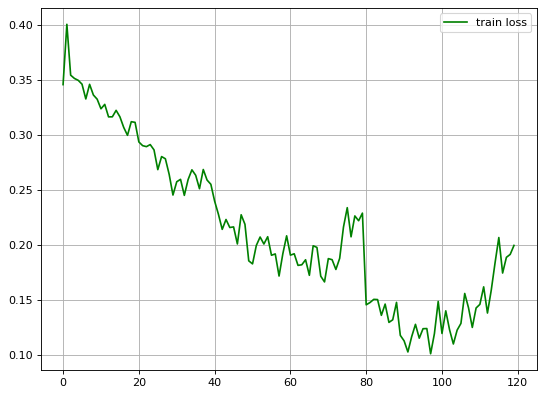

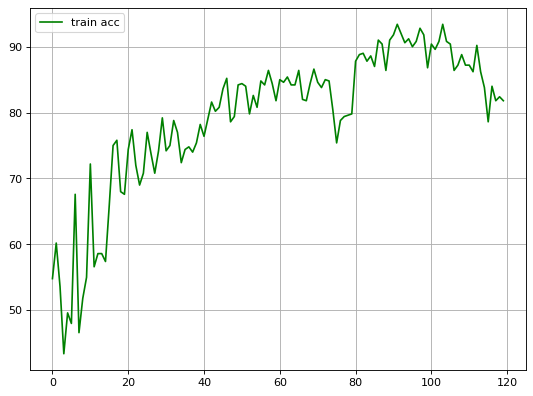

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, color='g', label='train loss')
# plt.plot(val_loss, color='r', label='val loss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_acc, color='g', label='train acc')
# plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()



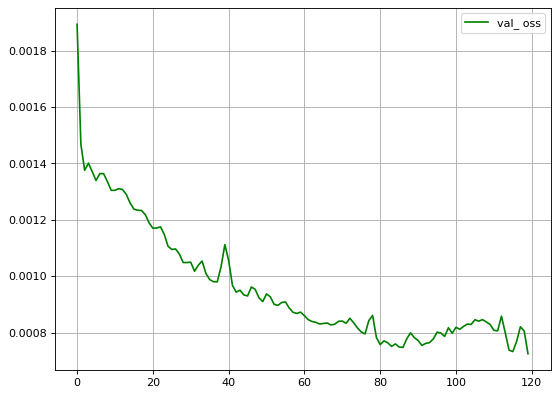

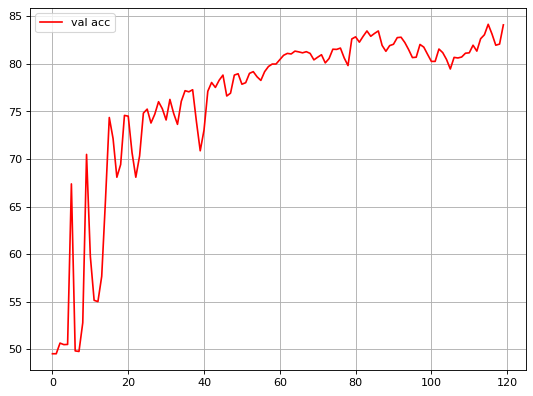

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(val_loss, color='g', label='val_ oss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()

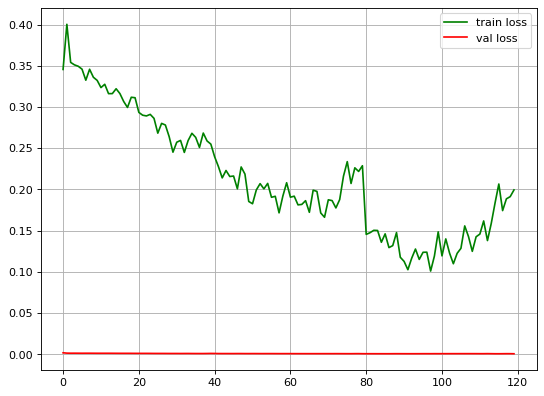

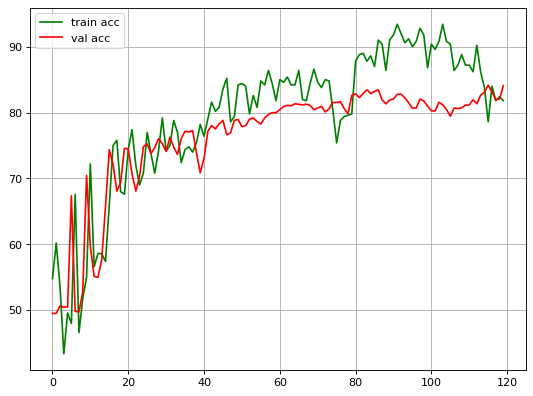

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, color='g', label='train loss')
plt.plot(val_loss, color='r', label='val loss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_acc, color='g', label='train acc')
plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()


In [ ]:
v_loss, v_acc = valid_eval(rnn, x_val, y_val)
print(v_loss, str(v_acc)+'%')

tensor(0.0007) 84.1%
